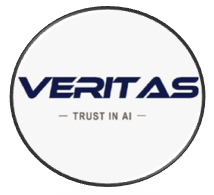
# Veritas Demo: Non-Python Classification Model with Custom Metrics

<p>   
    The <b>Veritas toolkit</b> is comprised of diagnosis tool and assessment tool.
    This scenario is to build a NON Python credit scoring model and use daignosis tool to evaluate model & produce
    the model artifact required by assessment tool to generate the fairness assessment report.
</p>    
<p>    
    Credit scoring model is a binary classification model for prediction customer loan repayment. <br/>
    Steps to perform: <br/>
    1. Loading Data <br/>
    2. Building non python model  <br/>  
    &nbsp;&nbsp;&nbsp;&nbsp;2.1 Create model object using Model Wrapper <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.2 Train non python model (Optional) <br/><br/>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The model is trained using libsvm, a C++ library for training SVM models. <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Homepage: https://www.csie.ntu.edu.tw/~cjlin/libsvm/index.html<br/>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;It can used by executing the following commands at a terminal.<br/>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Train : svm-train -t 0 cs_train_smpl.data <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Test : svm-predict cs_test.data cs_train_smpl.data.model cs_test.out<br/><br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.3 Test non python model<br/>
    3. Adding custom metrics <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;3.1 Create new custom metrics using NewMetric <br/>
    4. Diagnose Model Fairness in <b>Diagnosis tool</b> <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;4.1 compute performance and fairness metrics <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;4.2 compute feature importance analysis <br/>
</p>


In [ ]:
import numpy as np
import pandas as pd
import pickle
import sys  
from pathlib import Path
# making veritas available in search path
sys.path.append('../../')
import os
%load_ext autoreload
%autoreload 2

# 1. Loading Data

Dataset used is generated from : [Kaggle hosted UCI credit card dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset)

In [ ]:
pth = os.path.abspath('.')
file = os.path.join(pth, 'data',"credit_score_dict.pickle")
input_file = open(file, "rb")
cs = pickle.load(input_file)

#Reduce into two classes
cs["X_train"]['MARRIAGE'] = cs["X_train"]['MARRIAGE'].replace([0, 3],1)
cs["X_test"]['MARRIAGE'] = cs["X_test"]['MARRIAGE'].replace([0, 3],1)
#Model Contariner Parameters
y_true = np.array(cs["y_test"])
y_pred = np.array(cs["y_pred"])
y_train = np.array(cs["y_train"])
p_var = ['SEX', 'MARRIAGE']
p_grp = {'SEX': [1], 'MARRIAGE':[1]}
x_train = cs["X_train"]
x_test = cs["X_test"]

model_type = 'credit'
y_prob = cs["y_prob"]

#sample feature_imp
sample = os.path.join(pth, 'data',"sample.csv")
feature_imp = pd.read_csv(sample)


df_sampled = pd.read_csv(os.path.join(pth, 'data',"libsvm_train.csv")) 
x_train = df_sampled[df_sampled.columns[1:]]
y_train = df_sampled[df_sampled.columns[0]]
y_prob = None

lib_path = 'C:/Users/nisith.singh/Desktop/MAS/libsvm-3.20/windows'
model_name = 'libsvm_train.data.model'

# 2. Building non python model

## 2.1 Create model object using Model Wrapper

In [ ]:
from veritastool.model.modelwrapper import ModelWrapper
import subprocess
import csv

class libSVMwrapper(ModelWrapper):
    """
    Abstract Base class to provide an interface that supports non-pythonic models.
    Serves as a template for users to define the

    """

    def __init__(self, lib_path, model_obj_name='libsvm_mdl', output_dir='.' ):        
        self.path = lib_path
        self.model_obj_name = model_obj_name
        self.output_dir = output_dir
          
    def fit(self, X, y):                    
        
        y = pd.DataFrame(y)
        trainDf = pd.concat([y,X],axis = 1)
        
        train_csv = os.path.join(self.output_dir,"temp_train.csv")
        libsvm_train_csv = os.path.join(self.output_dir,"temp_train.data")
        
        trainDf.to_csv(train_csv,index=False)
        self.convert_df_to_libsvm_format(train_csv)
        
        train_cmd = os.path.join(self.path,"svm-train.exe -t 0 -b 1 "+libsvm_train_csv)+" {}".format(self.model_obj_name) 
        process = subprocess.Popen(train_cmd.split(), stdout=subprocess.PIPE)
        output, error = process.communicate()

        #cleanup temp files
        os.remove(train_csv)
        os.remove(libsvm_train_csv)

    def predict(self, x_test): 
       
        testData = x_test 
        
        test_csv = os.path.join(self.output_dir,"temp_test.csv")
        libsvm_test_csv = os.path.join(self.output_dir,"temp_test.data")
        output_file = os.path.join(self.output_dir,"test.out")
        
        testData.to_csv(test_csv, index=False)
        self.convert_df_to_libsvm_format(test_csv)

        test_cmd = os.path.join(self.path,"svm-predict.exe -b 1 ")+" {} {} {}".format(libsvm_test_csv,self.model_obj_name,output_file)  

        process = subprocess.Popen(test_cmd.split(), stdout=subprocess.PIPE)
        output, error = process.communicate()
        #print(output, error)
        
        try:
            f = open(output_file)
            lines = f.readlines()
            test_preds = pd.DataFrame([ line.split() for line in lines])
            test_preds.columns = test_preds.iloc[0]
            test_preds = test_preds[1:].reset_index(drop=True)            
            test_preds['prob'] = test_preds.apply(lambda x: x[0] if x[0]>x[1] else x[1], axis=1) 

            test_preds['prob'] = test_preds['prob'].astype(float)
            self.y_prob = test_preds['prob'].values
            test_preds['labels'] = test_preds['labels'].astype(int)
            y_pred = test_preds['labels'].values
            f.close()
        except:
            f.close()

        #cleanup temp files
        os.remove(test_csv)
        os.remove(output_file)
        #os.remove("temp_train.data.model")
        return y_pred
    
    def get_prob_est(self):
        return self.y_prob

    def construct_line(self, line):
        new_line = []
        for i, item in enumerate(line):
            if (i == 0):
                new_line.append(item)
                continue
            else:
                if item == '' or float(item) == 0.0:
                    continue
                elif item=='NaN':
                    item="0.0"
                new_item = "%s:%s" % (i + 1, item)
                new_line.append(new_item)
        new_line = " ".join(new_line)
        new_line += "\n"
        return new_line


    def convert_df_to_libsvm_format(self, file):

        input_file = file
        output_filename = file.split('.')[0]

        try:
            output_file = output_filename+".data" 
        except IndexError:
            output_file = input_file+".out"

        try:
            skip_headers = True 
        except IndexError:
            skip_headers = 0

        i = open(input_file, 'rt')
        o = open(output_file, 'wb')

        reader = csv.reader(i)

        if skip_headers:
            headers = reader.__next__()

        for line in reader:
            new_line = self.construct_line(line)
            o.write(new_line.encode('utf-8'))

In [ ]:
rej_libsvm = libSVMwrapper(lib_path,model_name,'data/tmp/')


<h5 align="center">Table 1: libSVMwrapper parameters   </h5>

| Var Name    | Description   |Compulsory   |
| :---        |:----:  |          ---: |
| lib_path      |path where libsvm library executables exist|Yes|
| model_obj_name|full path to model file with model name |No|
| output_dir|folder to save temp files and model |No|

## 2.2 Train non python model
### (Optional. User can skip step to assess existing model )

In [ ]:
#rej_libsvm.fit(x_train,y_train)

## 2.3 Test non python model

In [ ]:
# Get the label predictions and label prediction probability estimates
y_pred = rej_libsvm.predict(x_test) 
y_prob = rej_libsvm.get_prob_est()

# 3. Adding custom metrics

## 3.1 Create new custom metrics using NewMetric

In [ ]:
from veritastool.metrics.newmetric import NewMetric
from sklearn.metrics import average_precision_score

class AP(NewMetric):
    metric_type = "perf"
    metric_group = "classification"
    metric_name = "ap"
    metric_definition = "Average Precision Score"
    metric_parity_ratio = "parity"
    enable_flag = True
    
    def compute(obj, **kwargs):
        y_true = obj.y_true[0]
        y_prob = obj.y_prob[0]
        
        if y_prob is None:
            return None
        
        if 'y_pred_new' in kwargs:
            y_prob=kwargs['y_pred_new'][0]
        
        if obj.sample_weight[0] is None :
            ap = average_precision_score(y_true=y_true, y_score=y_prob)
        else: 
            sample_weight = obj.sample_weight[0]
            ap = average_precision_score(y_true=y_true, y_score=y_prob, sample_weight=obj.sample_weight[0])
        
        return ap

class AP_Parity(NewMetric):
    metric_type = "fair"
    metric_group = "classification"
    metric_name = "ap_parity"
    metric_definition = "Average Precision Score Parity"
    metric_parity_ratio = "parity"
    enable_flag = True

    def compute(obj, **kwargs):
        mask = obj.feature_mask[obj.curr_p_var]
        y_true = obj.y_true[0]
        y_prob = obj.y_prob[0]
        
        if y_prob is None:
            return (None, None)
            
        if 'y_pred_new' in kwargs:
            y_prob=kwargs['y_pred_new'][0]

        if obj.sample_weight[0] is not None: 
            sample_weight_p = np.array(obj.sample_weight[0])[mask]
            sample_weight_u = np.array(obj.sample_weight[0])[~mask]

        else:
            sample_weight_p = None
            sample_weight_u = None

        ap_parity_p = average_precision_score(y_true=np.array(y_true)[mask], y_score=np.array(y_prob)[mask], sample_weight=sample_weight_p)
        ap_parity_u = average_precision_score(y_true=np.array(y_true)[~mask], y_score=np.array(y_prob)[~mask], sample_weight=sample_weight_u)
            
        return (ap_parity_p - ap_parity_u, ap_parity_p)

# 4. Diagnose Model Fairness

## Initializing Veritas Diganosis Library

In [ ]:
from veritastool.model.model_container import ModelContainer
from veritastool.fairness.credit_scoring import CreditScoring

In [ ]:
#Create Model Container
container = ModelContainer(y_true,  p_var, p_grp,model_type, model_name,  y_pred, \
                           y_prob, y_train, feature_imp = feature_imp, x_train=x_train, x_test=x_test, \
                           model_object=rej_libsvm )

<h5 align="center">Table 2: Model Container parameters   </h5>

| Var Name    | Category       |Sub-category   | Description   |  Value        |  Compulsory   |
| :---        |    :----:      |   :----:      |          ---: |          ---: |        ---: |
| y_true      | data           | testing       | test set labels| array([0, 1, 1, ..., 1])   |Yes|
| y_pred      | data           | testing       | test set predicted labels | array([0, 1, 1, ..., 1])   |Yes|
| y_prob      | data           | testing       | test set predicted probabilities | array([0.56, 0.33, 0.11, ..., 0.98])|No|
| x_test      | data           | testing       | test set features | -      |No|
| y_train     | data           | training      | train set labels      | array([0, 1, 1, ..., 1])   |No|
| x_train     | data           | training      | train set features |-      |No|
| p_var       | protected vars |    -          | list of protected vars| [ 'SEX', 'MARRIAGE' ]      |Yes|
| p_grp       | protected vars |    -          | list of priveleged groups| { 'SEX': [ 1 ] , 'MARRIAGE': [ 1 ] }   |Yes|
| model_obj   | model          |    -          | model to assess| -      |No|
| model_type  | model          |    -          | type of model | 'credit'    |Yes|
| model_name  | model          |    -          | name of model | 'credit scoring'   |No|
| feature_imp | model          |    -          | list of feature imps for model| -   |No|


In [ ]:
#Create Use Case Object
cre_sco_obj= CreditScoring(model_params = [container], fair_threshold =80, fair_concern = "eligible", \
                           fair_priority = "benefit", fair_impact = "significant", perf_metric_name = "accuracy", \
                           fair_metric_name = "equal_opportunity")

<h5 align="center">Table 3: Credit Scoring parameters   </h5>

| Var Name    | Category       | Description   |  Value        |Compulsory|
| :---        |    :----:      |          ---: |          ---: |---:|
| model_params| model containers | list of model containers | -  |Yes|
| fair_metric_name| metric name |primary fairness metric | "auto" or any of supported ones <br/> like "equal_opportunity" |No|
| perf_metric_name      | metric name |primary performance metric |"balanced_acc"   |No|
| fair_concern | fair_metric selection | most concerned cohort |"eligible" or "inclusive" or "both" |No|
| fair_priority| fair_metric selection|top priority to be for fairness assessment | "benefit" or "harm" |No|
| fair_impact  | fair_metric selection |impact magnitude and type | "normal" or "significant" or "selective"   |No|
| fair_threshold | fairness metric thresolding |threshold used for assessment|actual value [0,1] or p% rule (1,100]|Yes|


## Starting Fairness diagnosis

In [ ]:
cre_sco_obj.evaluate()

In [ ]:
#This step could take time since it's dependent on the non python library being used.
cre_sco_obj.feature_importance()